### The Marcenko-Pastur Theorem

관측값을 생성하는 기본 프로세스의 평균 0과 분산 $\sigma^2$인 독립적이고 동일하게 분포된 랜덤 관측값 X의 행렬을 고려하자. 행렬 $C = T^{-1}X^\prime X$는 Marcenko-Pastur Probability Density Function으로 점근적으로 수렴하는 고유값을 가진다

$$f(\lambda) = \begin{cases}
\frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2}, & \mbox{     if }\lambda \in [\lambda_-, \lambda_+] \\
0, & \mbox{     if }\lambda \notin [\lambda_-, \lambda_+]
\end{cases}$$

여기서 최대 기대 고유값은 $\lambda_+ = \sigma^2(1 + \sqrt{N/T})^2$이고, 최소 기대 고유값은 $\lambda_- = \sigma^2 (1-\sqrt{N/T})^2$이다. $\sigma^2 = 1$일 때 $C$는 $X$와 연관된 상관 행렬이다. 

아래와 같이 Marcenko-Pastur 분포가 Random Matrix의 고유값을 얼마나 근접하게 설명하는지 보여 준다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import *

In [2]:
x = np.random.normal(size = (10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar = 0))
pdf0 = marchenko_pastur_prob_distribution(1.0, q = x.shape[0] / float(x.shape[1]), pts = 1000)
pdf1 = fit_kde(
    np.diag(eVal0),
    bWidth = .01
) # empirical prob. dist

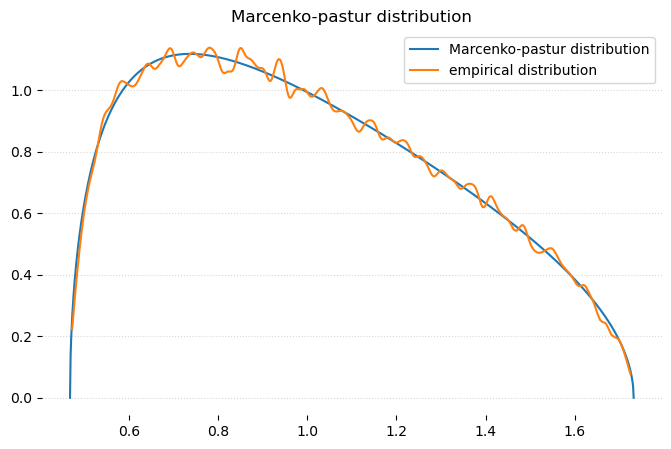

In [3]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(pdf0, label = 'Marcenko-pastur distribution')
ax.plot(pdf1, label = 'empirical distribution')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Marcenko-pastur distribution')
plt.show()

### Random Matrix with Signal

경험적 상관 행렬에서 모든 고유 벡터가 랜덤하지 않을 수 있다 (사실 대부분의 경우에서 고유 벡터는 랜덤하지 않을 것이다). 대부분의 금융시장에서는 신호는 약하고, 잡음은 굉장이 클 것이다. 랜덤 공분산 행렬에 신호를 추가하여 비교해 보자

signal이 존재하는 랜덤 행렬에서의 marcenko-pastur 분포

In [4]:
def get_random_covariance(nCols, nFacts) :
    w = np.random.normal(size = (nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size = nCols))
    return cov

In [5]:
alpha = 0.995 # noise ratio
nCols = 1000
nFacts = 100
q = 10

cov = np.cov(
    np.random.normal(size = (nCols * q, nCols)),
    rowvar = 0
)
cov = alpha * cov + (1 - alpha) * get_random_covariance(nCols, nFacts) # noise + signal
corr0 = covariance_to_correlation(cov)
eVal0, eVec0 = getPCA(corr0)

### Fitting the Marcenko–Pastur Distribution

신호가 있는 상태에서 marcenko-pastur dist 적합화를 진행하려면 다음과 같은 과정을 따라야 한다

In [6]:
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [7]:
pdf0 = marchenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

아래의 그림은 고유값 분포와 적합화된 마르첸코-파스퇴르 분포의 확률밀도함수를 나타낸다. 적합화된 마르첸코-파스퇴르 분포의 오른쪽에 있는 고유값은 잡음과 연관될 수 없으므로 신호와 관련이 있다. 이는 공분산 행렬에 주입한 요인 수와 동일하다. 공분산 행렬에 존재하는 희미한 신호에도 불구하고, 이 절차는 잡음과 관련된 고유값을 신호와 관련된 고유값에서 분리할 수 있었다. 적합화된 분포는 $\sigma^2 \approx 0.6768$을 의미하며, 분산의 약 32.32%만이 신호에 기인함을 나타낸다. 이는 금융 데이터셋에서 신호 대 잡음 비율을 측정하는 방법 중 하나인데, 신호 대 잡음 비율은 차익 거래 힘의 결과로 낮게 나타나는 것으로 알려져 있다.

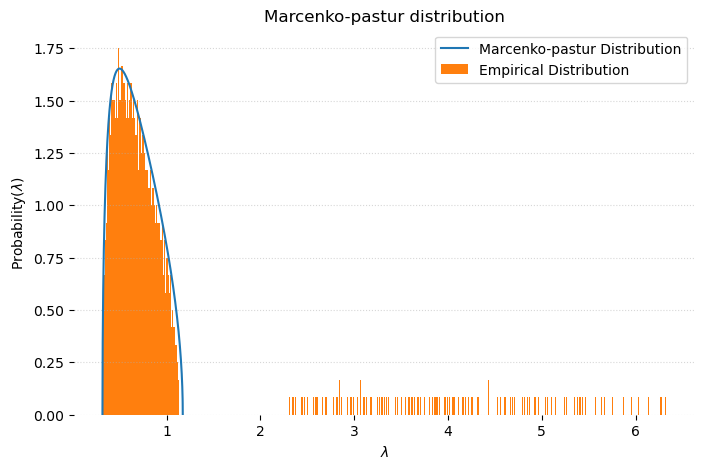

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(pdf0, label = "Marcenko-pastur Distribution")
ax.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Marcenko-pastur distribution')
plt.show()